In [2]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.7.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [3]:
data = scipy.io.loadmat('Data/burgers_shock_mu_01_pi.mat')  	# Load data from file
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [4]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [5]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [6]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        nu = 0.01/np.pi

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)    
        u_xx = tape.gradient(u_x, x_f)

        del tape

        f = u_t + (self.evaluate(g))*(u_x) - (nu)*u_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Solution Plot*

In [7]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

0.23502230522604572 0.23404906037192219 0.00097324485412354019 0.9590025379122511
0.22933238946946408 0.22860806059672306 0.00072432887274101086 0.9477675000867976
0.21656462481543559 0.20969400246173917 0.0068706223536964322 0.8605706219067621
0.21216994928944097 0.20627939732117867 0.0058905519682622854 0.8630361736422397
0.21022860084685696 0.20755012077775559 0.0026784800691013748 0.8846862718865859
0.20945584416642865 0.20636669830828311 0.003089145858145547 0.8809333178376607
0.20685245553849291 0.20188323581167691 0.0049692197268160045 0.8749921994686274
0.20500225587741863 0.19847201096942568 0.00653024490799295 0.8784960363386147
0.20347022936356327 0.19603588200464583 0.0074343473589174253 0.8872040057816981
0.20296442681805724 0.19522798448342993 0.0077364423346273 0.890860603324577
0.20206499238697809 0.19366665747084466 0.0083983349161334368 0.8945015683514065
0.20113503642020114 0.19156349017657337 0.0095715462436277727 0.8968230681517295
0.20064654342399346 0.18688925499

0.070359240758411976 0.049018908298991339 0.021340332459420634 0.5191799879915157
0.069423746144255949 0.04916564354272164 0.020258102601534305 0.5232641059663355
0.0684645249550278 0.049343071681043175 0.019121453273984637 0.5303620220287057
0.067761935597914519 0.048260547114129963 0.019501388483784562 0.5276406221152541
0.06732265836044958 0.047815032220444129 0.019507626140005448 0.5291127161449752
0.067142651578408166 0.046794301421840656 0.020348350156567514 0.5234731770438538
0.066968127692547508 0.046627209200705518 0.02034091849184199 0.5233887340003405
0.066843808371929075 0.046480495751866593 0.020363312620062475 0.5234085089070075
0.066624637413826238 0.046393905797432342 0.020230731616393903 0.5244079330549393
0.066187422276019925 0.047039870257116284 0.019147552018903634 0.5288404585386213
0.065201722030272649 0.04864071685739374 0.016561005172878913 0.5420987538976934
0.064131634788763381 0.050276537848763771 0.013855096939999605 0.5564937789040572
0.06298312695015687 0.

0.027173135688106306 0.015654541341161246 0.01151859434694506 0.3734395812008571
0.02710851397287678 0.015638995388198251 0.011469518584678528 0.372916177022488
0.027014972070645311 0.015379320447195598 0.011635651623449712 0.3710564024944582
0.026817266492868912 0.015152197142019413 0.011665069350849497 0.3708567535236507
0.026643832671884887 0.01499304040737142 0.011650792264513465 0.369645795645309
0.026439138603152196 0.014780835245514759 0.011658303357637437 0.3684138605281129
0.026181571802588958 0.014671245564038782 0.011510326238550176 0.36668961529084904
0.02577389061330565 0.014259203702753902 0.011514686910551747 0.36027464655094965
0.025286961175849939 0.014086124340983528 0.011200836834866411 0.3556451342183277
0.024602942231158179 0.013780939028685055 0.010822003202473125 0.3493909586982714
0.023681857390422251 0.013405922164103841 0.01027593522631841 0.34578840444028175
0.0232864351453539 0.012974978907182117 0.010311456238171783 0.3407878271611891
0.022767025712588373 0

0.0063775656905781077 0.0021388415915280174 0.00423872409905009 0.2607575926350752
0.0063057803279870763 0.0020393521599119079 0.0042664281680751684 0.25842838361020476
0.0062258541155330764 0.0020225609087552903 0.0042032932067777862 0.2575333139482809
0.0061490147009341887 0.0019283340933720242 0.0042206806075621647 0.25821670188510004
0.0060610534568128985 0.0018690377506180703 0.0041920157061948278 0.25832984189455516
0.0060007331725027 0.0018289568577183016 0.0041717763147843985 0.2593233203494796
0.005960792809607725 0.0018410376641716591 0.0041197551454360661 0.25885310086565866
0.0059312873422651593 0.0018476938457063158 0.0040835934965588435 0.25866146625225744
0.00589721715198409 0.0018316201200398888 0.0040655970319442014 0.25826973403996256
0.0058283907710643687 0.0017748192321115439 0.0040535715389528248 0.25708880610239254
0.0056772740373463738 0.0016980625044473393 0.0039792115328990347 0.2561866307004907
0.0054875802148013353 0.0016148085505333406 0.0038727716642679949 

0.0016895342108844465 0.00059442272673110471 0.0010951114841533417 0.19326713821616695
0.001660656070111679 0.000614044327799982 0.0010466117423116969 0.1977087613272358
0.0016425987535922905 0.00060048994585204052 0.0010421088077402498 0.19916674922376884
0.0016320020696505861 0.000596066327392878 0.001035935742257708 0.19956101531527115
0.0016261932559649027 0.00058646671292739161 0.0010397265430375112 0.20033646766279353
0.0016208366477419081 0.00058501685698832866 0.0010358197907535795 0.20052208822138323
0.0016114652534242248 0.000582286424613678 0.0010291788288105468 0.20053023564667333
0.0015985918488399164 0.00058646814639056973 0.0010121237024493467 0.20082210871270256
0.0015841354945708127 0.00058814127158738423 0.00099599422298342843 0.20097809639779876
0.0015659853868326265 0.00058956689772337776 0.00097641848910924871 0.20069934538952272
0.0015491669336378277 0.00059194168245008821 0.00095722525118773947 0.20125577127977382
0.0015240833892589448 0.0005825045148030683 0.000

0.00081866488476326871 0.00028389138671083228 0.00053477349805243642 0.17132020184114333
0.00081577697730228992 0.00028655942364085295 0.000529217553661437 0.1687741756761397
0.00081177968619231423 0.00028614260518841818 0.0005256370810038961 0.1668076120178828
0.00080820043689902653 0.00027543046344832194 0.00053276997345070459 0.16141507706244157
0.00080490913547693948 0.00027335485918797046 0.000531554276288969 0.15905374774788944
0.00080088875468651275 0.00026579782426694795 0.00053509093041956475 0.1555557882767037
0.0007969307811205754 0.00025701405995229938 0.000539916721168276 0.15172212823462713
0.00079278986467921757 0.00024019265427822664 0.000552597210400991 0.1397126512469997
0.00078520045706130862 0.00023643370085194514 0.00054876675620936348 0.13742355530877906
0.00078083041681490327 0.0002311663456297624 0.00054966407118514085 0.13187783328939617
0.00077779553105532685 0.00023240750440522219 0.00054538802665010471 0.13238321456892319
0.00077581746132764106 0.00022750474

0.00044572711989772839 8.873211879331449e-05 0.0003569950011044139 0.06618271883463418
0.00043849822706179222 9.6798146612497266e-05 0.00034170008044929497 0.06496910132799959
0.00043684312108874896 9.5509677344752671e-05 0.00034133344374399628 0.061456233016929505
0.00043420061853189658 9.54125946472555e-05 0.00033878802388464109 0.062274328560219576
0.000432944937768236 9.4521244970755282e-05 0.0003384236927974807 0.061618993968347295
0.00043193374364307226 9.5749763400392808e-05 0.00033618398024267944 0.06105507021625727
0.00043140025275855733 9.59978160025754e-05 0.00033540243675598191 0.06048845542755545
0.0004306932073379875 9.6212902498404778e-05 0.00033448030483958273 0.060430409554832046
0.00042945417913668472 9.61054593765886e-05 0.00033334871976009611 0.06047159128084822
0.00042765953699426188 9.3667313820920974e-05 0.00033399222317334089 0.06017960541296503
0.00042442298124695585 9.3155318679239788e-05 0.00033126766256771608 0.059744837843317584
0.00041850725423238919 8.960

0.00024631903230262596 5.2688828270342308e-05 0.00019363020403228364 0.014703472605803599
0.00024465488943756604 5.4136992686047083e-05 0.00019051789675151898 0.015088931139187361
0.00024251142397449513 5.591784064327566e-05 0.00018659358333121946 0.014980249604275813
0.00023938638853783706 5.8919406013121564e-05 0.00018046698252471551 0.015282548165268544
0.00023762573267439285 5.9367901686623807e-05 0.00017825783098776905 0.015247066283483265
0.00023479674527124739 5.8322343142643059e-05 0.00017647440212860432 0.01523730243470324
0.00023210427623784644 5.6405843831748359e-05 0.00017569843240609808 0.015278983780302858
0.00022878726920615963 5.3947531941352224e-05 0.0001748397372648074 0.015586169724210066
0.00022547314259525658 5.2301113907805185e-05 0.0001731720286874514 0.016145254985382815
0.00022280877781631582 5.1551646052634995e-05 0.00017125713176368082 0.016737739586942753
0.00022170156140520334 5.1221590380567448e-05 0.00017047997102463591 0.016905289978365025
0.000220624220

0.00014251172494792342 4.4291201700882714e-05 9.82205232470407e-05 0.020482510119199836
0.00014097297033801968 4.3871638123384917e-05 9.7101332214634767e-05 0.020631960878202744
0.00014008492092604032 4.3755799045311705e-05 9.6329121880728619e-05 0.020956327521287232
0.00013929805576180259 4.3773671275145349e-05 9.5524384486657236e-05 0.02112332279252276
0.00013760856144493823 4.4230359526268086e-05 9.3378201918670152e-05 0.02106645444140561
0.00013692505453857391 4.3819928407270911e-05 9.3105126131303e-05 0.020554619924136115
0.00013621660241891462 4.3786597315303912e-05 9.2430005103610711e-05 0.02057055141796678
0.00013567590358031122 4.3508669582677604e-05 9.2167233997633621e-05 0.021000909854288482
0.00013525574651183426 4.3354255403302706e-05 9.1901491108531568e-05 0.021442821957848662
0.00013486261376001517 4.3084520199820458e-05 9.1778093560194722e-05 0.02182182331722979
0.00013443874951856816 4.2671660000343242e-05 9.1767089518224909e-05 0.022185109576702625
0.00013404965661942

9.8290739057993768e-05 2.3139595990560336e-05 7.5151143067433428e-05 0.02230225953126937
9.8122979865243544e-05 2.28213358825495e-05 7.5301643982694037e-05 0.0217770219611435
9.787789636962429e-05 2.2567836974424659e-05 7.5310059395199637e-05 0.021345699028433637
9.7601029712027058e-05 2.2429808972191479e-05 7.5171220739835579e-05 0.021302713105730536
9.7249490870389681e-05 2.2239310646559547e-05 7.5010180223830138e-05 0.02142225465163819
9.6779538805085255e-05 2.2463370899400817e-05 7.4316167905684444e-05 0.02184878637955161
9.63260445058924e-05 2.2657820361954183e-05 7.3668224143938219e-05 0.022340981928115903
9.6017172540216583e-05 2.2934629926136936e-05 7.3082542614079647e-05 0.02248193710146468
9.5798373161861417e-05 2.2827808917049291e-05 7.2970564244812129e-05 0.022261661201020008
9.5454112990505893e-05 2.2727324135948169e-05 7.272678885455772e-05 0.021805874645512396
9.5206848997195716e-05 2.2777212720813978e-05 7.2429636276381742e-05 0.021665619318808893
9.4894631662827556e-05

7.5654289666506985e-05 1.9073463807212978e-05 5.6580825859294e-05 0.010489182466128094
7.5605557082285689e-05 1.9493257411719681e-05 5.6112299670566005e-05 0.010893818765973918
7.5433234368369744e-05 1.9229102079767645e-05 5.62041322886021e-05 0.01078697773213366
7.5399685811037071e-05 1.9023155852694656e-05 5.6376529958342412e-05 0.010738248630935428
7.5342761521776652e-05 1.892982522654782e-05 5.6412936295228836e-05 0.010652231186345854
7.5307538663598009e-05 1.8906290910965559e-05 5.6401247752632453e-05 0.010669911304329323
7.5260870419525445e-05 1.8848546451785195e-05 5.6412323967740243e-05 0.010658008716578925
7.5213026598363621e-05 1.8737285356754126e-05 5.6475741241609491e-05 0.010595927992235549
7.51482419225329e-05 1.8621974193020883e-05 5.6526267729512016e-05 0.010512423439124058
7.5088953671250758e-05 1.8512545112726769e-05 5.6576408558523996e-05 0.010326265477635233
7.50040447048848e-05 1.8450940994323824e-05 5.6553103710560985e-05 0.010302885445737889
7.4914480679327093e-0

5.42556790697026e-05 9.9790364817528236e-06 4.4276642587949771e-05 0.005938046960343138
5.4090936556795813e-05 9.6849859412770079e-06 4.44059506155188e-05 0.005814703073536227
5.39372571808333e-05 9.4333197090106245e-06 4.4503937471822675e-05 0.005651713894902932
5.3854690011277096e-05 9.3805517804484349e-06 4.4474138230828661e-05 0.005620327324974831
5.366279494120786e-05 9.22960995684301e-06 4.4433184984364848e-05 0.005625190990545012
5.351639164092607e-05 9.2408243164910422e-06 4.4275567324435028e-05 0.0056953452025196106
5.3350073593716715e-05 9.40985151924837e-06 4.3940222074468348e-05 0.005800821267914323
5.3211341538412788e-05 9.5466333051080723e-06 4.366470823330472e-05 0.005656540997418143
5.30644830829916e-05 9.65214560783037e-06 4.3412337475161223e-05 0.005566531127495388
5.2964350012527455e-05 9.710907173104823e-06 4.325344283942263e-05 0.005490510933282534
5.2888291356181524e-05 9.6888489450488343e-06 4.3199442411132689e-05 0.005448888628184832
5.28169630571504e-05 9.66780

4.1787334221861278e-05 8.8597554598525554e-06 3.2927578762008721e-05 0.005419882728253167
4.1694749655141915e-05 8.8341484502926152e-06 3.28606012048493e-05 0.005344432349905742
4.1560938305155621e-05 8.8461558934282235e-06 3.27147824117274e-05 0.005330635160286364
4.1468540243971517e-05 8.9209091417054823e-06 3.2547631102266033e-05 0.005302212859106682
4.1379836991459307e-05 9.0102963613185883e-06 3.236954063014072e-05 0.00532137806515987
4.1319589619519335e-05 9.0751207377872662e-06 3.2244468881732071e-05 0.005308014252772663
4.1287503755820173e-05 9.0835591216612583e-06 3.2203944634158916e-05 0.005267890140850782
4.124505293526048e-05 9.0976948845454458e-06 3.2147358050715036e-05 0.005223564720433419
4.1196299232905473e-05 9.1221158945165772e-06 3.2074183338388895e-05 0.005148940793927506
4.1147667849526709e-05 9.0915085936897917e-06 3.2056159255836918e-05 0.005085084308415831
4.1094435210036036e-05 9.1079822908313516e-06 3.1986452919204686e-05 0.005030980380758275
4.102199208509580

3.5336677907694161e-05 6.4671732875424635e-06 2.8869504620151696e-05 0.004936478736463309
3.5264601599994979e-05 6.4986997721254682e-06 2.8765901827869512e-05 0.004892209924064197
3.5136632219908353e-05 6.4682775306687664e-06 2.8668354689239585e-05 0.004900550809827778
3.4991940177396105e-05 6.509808242328902e-06 2.84821319350672e-05 0.005077610628351495
3.4868284309255032e-05 6.5171748361393257e-06 2.8351109473115706e-05 0.0051674218143757875
3.4771610354963365e-05 6.4836921275710969e-06 2.8287918227392269e-05 0.005097826524468062
3.4714125560947985e-05 6.4148359126736781e-06 2.829928964827431e-05 0.005021426628271963
3.4663052858177758e-05 6.3452000499616021e-06 2.8317852808216155e-05 0.004957389902986448
3.4590139331246118e-05 6.23123815638262e-06 2.83589011748635e-05 0.0049090394315942495
3.4522048012054543e-05 6.2451630964854862e-06 2.8276884915569059e-05 0.004988596092946244
3.4440582755978506e-05 6.2932052458858461e-06 2.8147377510092658e-05 0.00508135048778264
3.439030405543402

2.8285365502181633e-05 4.091917418346218e-06 2.4193448083835414e-05 0.0035127186624878868
2.821967725323058e-05 4.1141442310700269e-06 2.4105533022160552e-05 0.0035045382345721935
2.8176365336688567e-05 4.0283432769140171e-06 2.4148022059774549e-05 0.0035989063970985552
2.8167423330220623e-05 4.1219672920487417e-06 2.404545603817188e-05 0.0035902950799196077
2.8070967573460932e-05 4.0934589837977363e-06 2.3977508589663196e-05 0.00364168353958699
2.8043630634150351e-05 4.0639308027234372e-06 2.3979699831426915e-05 0.0037430841528232678
2.8008526717317636e-05 4.067150233598743e-06 2.3941376483718895e-05 0.0037343410800415875
2.7971733520553705e-05 4.0774814581833562e-06 2.3894252062370351e-05 0.0037747540417349037
2.7935506745140169e-05 4.0651879753783448e-06 2.3870318769761825e-05 0.0038516377934385395
2.7913507240101466e-05 4.0757547287271965e-06 2.3837752511374271e-05 0.0038572986477841205
2.7896050288849919e-05 4.0697979701994437e-06 2.3826252318650476e-05 0.003850854539677378
2.7873

2.3530345197046891e-05 3.81965491153847e-06 1.971069028550842e-05 0.0028689308520697776
2.3508557405419604e-05 3.8546123821975685e-06 1.9653945023222036e-05 0.0028443139675843475
2.3470075335549763e-05 3.8731409119838035e-06 1.9596934423565959e-05 0.0028459321231851715
2.342615808522412e-05 3.8959613883975996e-06 1.9530196696826518e-05 0.0028453620617879664
2.3387844062345308e-05 3.8843525970130862e-06 1.9503491465332223e-05 0.0028471359791670506
2.3333648107524311e-05 3.8582195097248519e-06 1.9475428597799459e-05 0.00283855399868371
2.3256946281289128e-05 3.8278281557516941e-06 1.9429118125537434e-05 0.002837648818704568
2.3149492035523007e-05 3.7843562664560121e-06 1.9365135769066994e-05 0.002840355025475661
2.3062026488424085e-05 3.7581349897362061e-06 1.9303891498687878e-05 0.00288808302696766
2.2957920165543913e-05 3.7005519431924912e-06 1.9257368222351423e-05 0.0028783937826422122
2.2862608323515149e-05 3.731528571730334e-06 1.9131079751784814e-05 0.002885840874210151
2.272970253

1.8940938343153759e-05 3.0595621764783575e-06 1.58813761666754e-05 0.0033748899918483993
1.8863286582557346e-05 3.0529976379202412e-06 1.5810288944637107e-05 0.0034487506311868727
1.8824663637865996e-05 3.0438911949364621e-06 1.5780772442929533e-05 0.0035012733525901047
1.8774498185243628e-05 3.0330632467698379e-06 1.574143493847379e-05 0.0035209563233098377
1.8722035769511367e-05 3.0263830636312733e-06 1.5695652705880095e-05 0.0034976889163603553
1.8676786802357349e-05 3.0290672989487765e-06 1.5647719503408572e-05 0.003499685767119247
1.863680497010539e-05 3.0593261972674178e-06 1.5577478772837971e-05 0.0034493331452722046
1.8592024275141095e-05 3.08549495246139e-06 1.5506529322679706e-05 0.003487073582465164
1.8532400357656605e-05 3.1307952820305993e-06 1.5401605075626004e-05 0.0034986924344671093
1.8493363563674785e-05 3.1655045513666769e-06 1.5327859012308108e-05 0.0034266307981157523
1.8453572399042248e-05 3.1714438229451039e-06 1.5282128576097144e-05 0.0033534273529270578
1.84185

1.6509108952589596e-05 2.98136755391687e-06 1.3527741398672728e-05 0.003214829767206376
1.6491228078098774e-05 2.9989381494740814e-06 1.3492289928624695e-05 0.0032057652733714914
1.6470464892017308e-05 2.9950703613250369e-06 1.3475394530692269e-05 0.003197364957434135
1.6445602047476918e-05 2.9853491260157943e-06 1.3460252921461125e-05 0.003209341869031347
1.6424402119036214e-05 2.9624297263523245e-06 1.3461972392683887e-05 0.003154033871825316
1.6388569514765682e-05 2.960265774536149e-06 1.3428303740229534e-05 0.00307171564040342
1.6341517199529476e-05 2.9569022750952221e-06 1.3384614924434253e-05 0.003090001962814379
1.6267263949080954e-05 2.9658001443304972e-06 1.3301463804750455e-05 0.00312698813580328
1.6224685998191611e-05 2.9912598008044148e-06 1.3233426197387195e-05 0.0032232271854674152
1.6181757632018283e-05 2.988155281862188e-06 1.3193602350156094e-05 0.0032721648586749624
1.61469604717438e-05 2.9666349878404228e-06 1.3180325483903377e-05 0.0033294358596443288
1.609749546629

1.4331273659312561e-05 2.3560867927361277e-06 1.1975186866576434e-05 0.0030775368113774362
1.4318960956133673e-05 2.3424845293150528e-06 1.197647642681862e-05 0.0030995004382416112
1.4308270758590091e-05 2.3168958031805496e-06 1.1991374955409541e-05 0.0031343190593154683
1.4296052007388906e-05 2.2976168378827636e-06 1.1998435169506142e-05 0.0032136260290710214
1.4285791288070051e-05 2.2900653121894832e-06 1.1995725975880568e-05 0.0032367675746646433
1.4272493645027004e-05 2.2685597806781286e-06 1.2003933864348875e-05 0.0032818897481095726
1.4262577834315966e-05 2.2623049586346978e-06 1.2000272875681268e-05 0.003274522593365248
1.4254259716879633e-05 2.2657067444945835e-06 1.1988552972385049e-05 0.0031787483061655433
1.4243890620284548e-05 2.2434603197049448e-06 1.2000430300579604e-05 0.003227837717418674
1.424323810551317e-05 2.2465299862600134e-06 1.1996708119253157e-05 0.0032815735739759365
1.4230875479094049e-05 2.25029151708438e-06 1.1980583962009669e-05 0.00325129452734071
1.42260

1.3048481123051011e-05 2.1013123086644621e-06 1.0947168814386549e-05 0.0030235042656616704
1.3021410325795624e-05 2.1030347403717207e-06 1.0918375585423903e-05 0.0030090830442615637
1.3007236294463062e-05 2.0893709628273104e-06 1.0917865331635752e-05 0.0029923024395278955
1.2975801191171538e-05 2.0806121622070541e-06 1.0895189028964483e-05 0.003032100907273584
1.2949553094592469e-05 2.0872023486545648e-06 1.0862350745937904e-05 0.0031083966395952633
1.2921846721765412e-05 2.1089851443654735e-06 1.0812861577399939e-05 0.003161840551634361
1.288990830611694e-05 2.1144792122285522e-06 1.0775429093888387e-05 0.0031511365244412436
1.2875147267150886e-05 2.123542410875982e-06 1.0751604856274905e-05 0.0031477823281524193
1.2835264330773964e-05 2.1492174262855683e-06 1.0686046904488396e-05 0.0030216306562470723
1.2808036886395805e-05 2.1385907235598008e-06 1.0669446162836005e-05 0.0029907122573371667
1.2777678157477863e-05 2.1326147520019586e-06 1.0645063405475905e-05 0.0029650567621416694
1.2

1.1703549071921174e-05 1.855022627009512e-06 9.848526444911662e-06 0.00338596581306452
1.1693219079513528e-05 1.8558951996834499e-06 9.8373238798300776e-06 0.0033686779542537347
1.1682286782254944e-05 1.8530074070721765e-06 9.829279375182768e-06 0.0033881609483523865
1.1670064025726722e-05 1.8536349209750276e-06 9.8164291047516946e-06 0.003415001699191549
1.1657845068371334e-05 1.8564467371228619e-06 9.8013983312484719e-06 0.0034535290559499676
1.1648380232345541e-05 1.8632578633314283e-06 9.7851223690141123e-06 0.0034465450123170884
1.1633784697702914e-05 1.8654360204849071e-06 9.7683486772180072e-06 0.0034468603974011957
1.1619919421853359e-05 1.8652119396866661e-06 9.7547074821666925e-06 0.0034428924788860262
1.16078712897738e-05 1.8545791078177655e-06 9.7532921819560348e-06 0.0034350290574441185
1.1594876016550005e-05 1.8494311315920745e-06 9.74544488495793e-06 0.003421935313893879
1.1580893649673686e-05 1.8441650992694871e-06 9.7367285504041989e-06 0.00337735361079045
1.1564380857

9.9106724109211563e-06 1.394732980678625e-06 8.5159394302425311e-06 0.0038540241144629558
9.8979162272219932e-06 1.3899277834693894e-06 8.5079884437526034e-06 0.0038136987716433607
9.8884154301993631e-06 1.3815321382965661e-06 8.5068832919027968e-06 0.003761805200594983
9.8816645685396955e-06 1.3735707270053254e-06 8.50809384153437e-06 0.0037661677770953654
9.87520925225835e-06 1.3678298858691013e-06 8.507379366389248e-06 0.00376488639553749
9.865350459277568e-06 1.3631756644982785e-06 8.50217479477929e-06 0.003756878891544696
9.8613838673034912e-06 1.3548782367821853e-06 8.5065056305213065e-06 0.0037860496741102738
9.85127460953182e-06 1.3535634263389254e-06 8.4977111831928944e-06 0.003737308534357704
9.8416644666822984e-06 1.3492406940716814e-06 8.4924237726106164e-06 0.0036863341398700364
9.8349625926815224e-06 1.3431826861171576e-06 8.491779906564364e-06 0.0036852885385627045
9.8274177176776669e-06 1.336774655494704e-06 8.4906430621829627e-06 0.003680718659111007
9.8210324062576544

8.9044958019958672e-06 1.0275871611245158e-06 7.8769086408713512e-06 0.003577234354415887
8.9009792260144138e-06 1.0265368487741795e-06 7.8744423772402349e-06 0.003600677264824372
8.8967210022124634e-06 1.0214950534461552e-06 7.8752259487663091e-06 0.0036570561091503278
8.89086938897385e-06 1.0176014276176541e-06 7.8732679613561958e-06 0.0037176165714879247
8.8833874355266637e-06 1.0125239826397517e-06 7.8708634528869124e-06 0.0037854314163903806
8.8736842299978841e-06 1.0100100773948718e-06 7.8636741526030121e-06 0.0038308000368536535
8.8634723502682382e-06 1.0037827782833707e-06 7.8596895719848679e-06 0.003852641220851753
8.85415761328092e-06 1.0019794263000659e-06 7.8521781869808551e-06 0.0037954590830495136
8.8444866586726215e-06 1.0031379816991706e-06 7.8413486769734515e-06 0.0037240965844205455
8.8362607364790618e-06 9.9909084996422868e-07 7.8371698865148338e-06 0.0037043802874742234
8.8251948500824912e-06 9.9874804426693128e-07 7.82644680581556e-06 0.0036926554013416834
8.814645

8.13720192070136e-06 8.732968108233977e-07 7.2639051098779613e-06 0.002668148345895818
8.1316371898563447e-06 8.72665271911605e-07 7.25897191794474e-06 0.0026369565497960353
8.12525232424931e-06 8.68560355517359e-07 7.2566919687319517e-06 0.0025893732810511536
8.120828752086695e-06 8.6597162225776316e-07 7.2548571298289314e-06 0.002622049173189362
8.1181301598702265e-06 8.6083103890341137e-07 7.2572991209668154e-06 0.0025980526600259796
8.1093595469752968e-06 8.6129673423070364e-07 7.2480628127445931e-06 0.002624564892638307
8.1060129293658621e-06 8.6371162018407211e-07 7.24230130918179e-06 0.0026628353075572363
8.10224768376031e-06 8.6476730352085913e-07 7.2374803802394513e-06 0.0027244268174323578
8.0985016783721482e-06 8.6157004721578335e-07 7.236931631156365e-06 0.002693299473080445
8.094950931104487e-06 8.6412499745872229e-07 7.2308259336457646e-06 0.002656552310207391
8.0924746222062471e-06 8.6450261823343986e-07 7.2279720039728075e-06 0.0026397462753872114
8.0886181521795419e-06

7.55185344446511e-06 9.1019850290846746e-07 6.6416549415566423e-06 0.003468285786785796
7.540181960431687e-06 9.0987528657512647e-07 6.63030667385656e-06 0.0034252376715829492
7.530192139734784e-06 9.1298691136687818e-07 6.6172052283679061e-06 0.0032953350348602878
7.520089737060328e-06 9.1307686239262128e-07 6.6070128746677062e-06 0.00323451748987247
7.5074324062667649e-06 9.1063325408617146e-07 6.5967991521805938e-06 0.003133219162865052
7.4993033907053042e-06 9.0952838785491754e-07 6.5897750028503869e-06 0.003130307361059585
7.489895811364592e-06 8.9898564033813279e-07 6.5909101710264592e-06 0.003257152268465464
7.4852280479828654e-06 8.9322077864621622e-07 6.59200726933665e-06 0.0033151551081604044
7.4798919118530479e-06 8.9284805406242123e-07 6.5870438577906264e-06 0.003446522591581984
7.4739708995660284e-06 8.9517045967888972e-07 6.5788004398871383e-06 0.0035474163205032458
7.46816620034361e-06 8.9982073471534271e-07 6.5683454656282676e-06 0.003537259117514062
7.4636021644674036e

6.7606175570308881e-06 7.9681699824435458e-07 5.9638005587865337e-06 0.004108212754623313
6.7569314417879368e-06 7.9370483268603e-07 5.9632266091019067e-06 0.0041294607309614595
6.7537122700846356e-06 7.89285754526153e-07 5.9644265155584824e-06 0.004078610736570643
6.7506456218606706e-06 7.8750240189419882e-07 5.9631432199664721e-06 0.004039839589123483
6.7445140068088434e-06 7.8288761114930513e-07 5.9616263956595379e-06 0.003967679817989026
6.7389120192742274e-06 7.7853927635702248e-07 5.9603727429172047e-06 0.0039370378461591
6.7340698277814704e-06 7.7501321249105989e-07 5.9590566152904104e-06 0.003906458250831189
6.7295762199271353e-06 7.7752286329126763e-07 5.9520533566358676e-06 0.003920040917641252
6.7270886723632551e-06 7.7840659150757752e-07 5.9486820808556775e-06 0.003827167765331175
6.7231873563391492e-06 7.7589439907719241e-07 5.9472929572619572e-06 0.0038566314313980407
6.7179579151003842e-06 7.731811208050112e-07 5.9447767942953728e-06 0.00389607995400195
6.710860041074282

6.1638141580894e-06 7.2065632614223293e-07 5.4431578319471673e-06 0.0026927708874349794
6.1557385729738524e-06 7.1445400436334528e-07 5.4412845686105073e-06 0.0026591510113731834
6.1531538485771091e-06 7.119321807026769e-07 5.4412216678744324e-06 0.0026725123481118594
6.1482890684137093e-06 7.1005792319879114e-07 5.4382311452149182e-06 0.002678965815655914
6.144737470434641e-06 7.0863099471706375e-07 5.4361064757175769e-06 0.0026923817968137705
6.1410519530868184e-06 7.0778907136491448e-07 5.4332628817219038e-06 0.0027005113925282565
6.13916381656624e-06 7.0908006519710151e-07 5.4300837513691386e-06 0.002698361439970467
6.1366173638038506e-06 7.1227662832878629e-07 5.4243407354750643e-06 0.0026631495350658983
6.1328933162006986e-06 7.0785391028521921e-07 5.4250394059154794e-06 0.0026626299314311042
6.1288102427179707e-06 7.0285393727322388e-07 5.4259563054447469e-06 0.002656626528470004
6.1242792927966529e-06 6.983771866552056e-07 5.4259021061414475e-06 0.002642400716022556
6.121268105

5.7020401235429589e-06 6.132645918889614e-07 5.0887755316539973e-06 0.0031104124330962367
5.6998484805986276e-06 6.1222189298171271e-07 5.0876265876169146e-06 0.0030961707887349147
5.6980247356622959e-06 6.1146251939875238e-07 5.0865622162635432e-06 0.003080065396573221
5.6963216995706495e-06 6.1342506264963985e-07 5.0828966369210096e-06 0.0030849194696926196
5.6940173882215982e-06 6.1469069981537811e-07 5.07932668840622e-06 0.0030829609415675466
5.6915608886369174e-06 6.1954533640412342e-07 5.0720155522327939e-06 0.0031061314552606532
5.688669692457109e-06 6.2243498194403454e-07 5.0662347105130748e-06 0.0031227858165978244
5.6848756073579313e-06 6.2734016225279382e-07 5.0575354451051371e-06 0.0031741314310068437
5.6838467070276851e-06 6.2704968923473891e-07 5.0567970177929466e-06 0.003207932470702574
5.6813569681280715e-06 6.2918803408460064e-07 5.0521689340434713e-06 0.0031851898131161553
5.6793355046520257e-06 6.2716104660091021e-07 5.0521744580511159e-06 0.003219080114267407
5.6744

5.3502727423335809e-06 5.5754322319046472e-07 4.7927295191431163e-06 0.002590988161816088
5.3463867394565741e-06 5.576161928188107e-07 4.7887705466377636e-06 0.002591873646485736
5.3421173466371815e-06 5.5774453713874364e-07 4.7843728094984376e-06 0.002611772839429183
5.3393309536365061e-06 5.562667884737381e-07 4.7830641651627679e-06 0.002635296852926977
5.3360640087268893e-06 5.5624327567658062e-07 4.7798207330503088e-06 0.0026933652959080885
5.3336264285847363e-06 5.5231213657309706e-07 4.7813142920116391e-06 0.0027441555985970854
5.331327722835446e-06 5.4764616342892522e-07 4.7836815594065209e-06 0.0027924582334734505
5.3294935256437591e-06 5.4629182701896153e-07 4.7832016986247971e-06 0.0028178387710921142
5.3265126003905022e-06 5.4368375379348661e-07 4.7828288465970159e-06 0.002824501274958229
5.3222802995469347e-06 5.430856185763431e-07 4.7791946809705914e-06 0.002809864618699911
5.3182266574708747e-06 5.433741207654265e-07 4.7748525367054484e-06 0.0028131705136124232
5.31650780

4.7958653702468674e-06 5.0726145632473575e-07 4.2886039139221317e-06 0.002886604518161386
4.7853161246198504e-06 5.0384300439699151e-07 4.2814731202228589e-06 0.0029275314610183296
4.7743819319255548e-06 5.0093321602755064e-07 4.2734487158980042e-06 0.003010851562847648
4.7687768762869252e-06 4.9233557606992545e-07 4.2764413002169994e-06 0.003011668701579895
4.7588957002260684e-06 4.8995838011734961e-07 4.268937320108719e-06 0.0030068752555411707
4.7455195979763185e-06 4.9301930801932128e-07 4.2525002899569973e-06 0.0029388596465886414
4.7379044671343913e-06 4.8580014573603793e-07 4.2521043213983531e-06 0.0030386184106128726
4.7323835142096541e-06 4.8695229925886061e-07 4.2454312149507936e-06 0.0030494262053548664
4.726089564285679e-06 4.9120301360865816e-07 4.2348865506770212e-06 0.0030619749992928406
4.7186862774503491e-06 4.8830569032360782e-07 4.2303805871267417e-06 0.0031243773500540485
4.7096531962436313e-06 4.86565634729146e-07 4.2230875615144856e-06 0.003219730278160485
4.70441

4.5537334102356911e-06 4.6544287730322331e-07 4.0882905329324675e-06 0.0030908662843292843
4.5502097892046922e-06 4.653778361834137e-07 4.0848319530212788e-06 0.0030236629407385156
4.548189756217715e-06 4.6778607522894166e-07 4.0804036809887735e-06 0.002970106015854462
4.5455620580538861e-06 4.688225640829246e-07 4.0767394939709618e-06 0.0029426996681285685
4.5431189640798408e-06 4.6985174336153083e-07 4.07326722071831e-06 0.0029596480033192703
4.5391258158694256e-06 4.7089723966308408e-07 4.0682285762063412e-06 0.00296865356765669
4.53604100487186e-06 4.7124712362651261e-07 4.0647938812453471e-06 0.002990889014517239
4.5320938333726421e-06 4.6996956910689788e-07 4.0621242642657443e-06 0.0030002765071453275
4.5302682384076277e-06 4.6667060219165131e-07 4.0635976362159763e-06 0.0030026349884417535
4.5265755884878554e-06 4.65964028283084e-07 4.0606115602047712e-06 0.0029906813945668543
4.5242900041029346e-06 4.6570895553641646e-07 4.0585810485665179e-06 0.002968266359777099
4.52001773792

4.3558798376040265e-06 4.27756634785947e-07 3.9281232028180795e-06 0.003396578412344168
4.3537400000072487e-06 4.2786278946237959e-07 3.9258772105448693e-06 0.003360313337039185
4.3509656963021608e-06 4.3016315658516508e-07 3.9208025397169954e-06 0.0033162670256440692
4.3488976635775872e-06 4.2840595304229822e-07 3.920491710535289e-06 0.0033472627970919477
4.34637654772991e-06 4.2661700990679916e-07 3.91975953782311e-06 0.0033886433390064173
4.3444454980148721e-06 4.2614380895679516e-07 3.9183016890580767e-06 0.003420580989812591
4.3438250709681327e-06 4.2519712393354679e-07 3.9186279470345859e-06 0.003450510653968153
4.3412617151965849e-06 4.2485151168825352e-07 3.9164102035083317e-06 0.0035011920799160423
4.3402051100981911e-06 4.2564578339793884e-07 3.9145593267002521e-06 0.003499237159243598
4.3388958625342666e-06 4.2792479679791659e-07 3.91097106573635e-06 0.0034726795266056096
4.3380081892701787e-06 4.2806105749516784e-07 3.909947131775011e-06 0.003470903050489642
4.3368362715172

4.0248468378659171e-06 4.4479878642636521e-07 3.580048051439552e-06 0.0035582108000593495
4.0219812143976367e-06 4.3878732763014107e-07 3.5831938867674956e-06 0.003488797239543338
4.0175181981300579e-06 4.4000155787844835e-07 3.5775166402516097e-06 0.003530547219099064
4.0101301232027509e-06 4.4256251265027653e-07 3.5675676105524743e-06 0.003576420531254182
4.0047206121950105e-06 4.4294341460594854e-07 3.5617771975890616e-06 0.003599623102023279
4.0011115857935425e-06 4.4317621635752256e-07 3.55793536943602e-06 0.0036194107198402924
3.9968034356774886e-06 4.4507331496212647e-07 3.5517301207153623e-06 0.003578977078665005
3.993877222021705e-06 4.4678471792538444e-07 3.5470925040963206e-06 0.0035446983770087087
3.9911889641696287e-06 4.4947683927055365e-07 3.5417121248990749e-06 0.0035469747357487254
3.9878269818860029e-06 4.5247160299143779e-07 3.5353553788945648e-06 0.0035729193852505467
3.9853926434704113e-06 4.543782341850818e-07 3.5310144092853296e-06 0.0035778018592286316
3.9840927

3.8426818637417184e-06 4.7120862897015262e-07 3.371473234771566e-06 0.003298902783121164
3.8392375685933469e-06 4.7055675059484944e-07 3.3686808179984975e-06 0.0032618904560630874
3.8356730011053567e-06 4.68216490630617e-07 3.36745651047474e-06 0.0032856293477820926
3.8326952280269973e-06 4.6364082280516464e-07 3.3690544052218326e-06 0.0033128677508058777
3.8297063995034467e-06 4.6111362820066084e-07 3.3685927713027859e-06 0.0033507516936931558
3.82665397345111e-06 4.6012998559428713e-07 3.3665239878568227e-06 0.0033758138217255267
3.825828824104392e-06 4.5486508577272556e-07 3.3709637383316663e-06 0.0033533990741286975
3.8217462946592447e-06 4.5581189735730629e-07 3.365934397301938e-06 0.003350446988360313
3.8188828021535019e-06 4.5687061901981809e-07 3.3620121831336834e-06 0.0033583212192506064
3.8160950650111063e-06 4.554382845072861e-07 3.36065678050382e-06 0.003326949181563497
3.8127963888892874e-06 4.5301297178220637e-07 3.3597834171070809e-06 0.003298220886991128
3.8104133919543

3.6134704383467756e-06 3.6966407100561132e-07 3.2438063673411642e-06 0.003462631192533905
3.6110123469948456e-06 3.6598903292268442e-07 3.2450233140721612e-06 0.003484952270726679
3.6080991076527457e-06 3.6204254382894804e-07 3.2460565638237978e-06 0.0034930584062760695
3.6067140176266266e-06 3.6128103628398925e-07 3.2454329813426371e-06 0.0034962369333239743
3.6036551073960965e-06 3.5772465160868453e-07 3.2459304557874122e-06 0.003478979092455962
3.6005485907841462e-06 3.5371061306603163e-07 3.2468379777181145e-06 0.0034413975947610565
3.5992988279047452e-06 3.5188994613671273e-07 3.2474088817680323e-06 0.0034288699854053096
3.5963458107878035e-06 3.5012238734623688e-07 3.2462234234415666e-06 0.00342419419394508
3.5942499916332982e-06 3.4976594093041723e-07 3.244484050702881e-06 0.003460621727166983
3.5916987718045468e-06 3.490853745529761e-07 3.2426133972515708e-06 0.0035306285256279917
3.5908864528454352e-06 3.4822020827548e-07 3.2426662445699552e-06 0.0035403774749981345
3.58860522

3.41121678098555e-06 3.4075467279233726e-07 3.0704621081932127e-06 0.0033085657759262385
3.4088928496899857e-06 3.409378954988884e-07 3.0679549541910974e-06 0.0032887398013680593
3.4069076905231569e-06 3.4024419494592007e-07 3.0666634955772369e-06 0.003277154465809556
3.4052882239831325e-06 3.4182479233300268e-07 3.06346343165013e-06 0.0032842988780888713
3.4037924908233016e-06 3.4255120559639255e-07 3.0612412852269089e-06 0.003328402575813181
3.4023330154271537e-06 3.4167587587432296e-07 3.0606571395528307e-06 0.0034018419796884316
3.400519314062931e-06 3.3931964694236866e-07 3.0611996671205622e-06 0.003479540207470073
3.3995461962608181e-06 3.3681020092495785e-07 3.06273599533586e-06 0.0035437888788612273
3.3969058722012967e-06 3.37229018621427e-07 3.0596768535798698e-06 0.0034509632830835952
3.3940429176668578e-06 3.3612426931874188e-07 3.057918648348116e-06 0.0034450429483759795
3.3919371270187116e-06 3.358863550279399e-07 3.0560507719907716e-06 0.0034234943203166395
3.389462670863

3.1656370323505e-06 2.440315902867018e-07 2.9216054420637983e-06 0.0038015060271683033
3.164054233430927e-06 2.4206171611606185e-07 2.921992517314865e-06 0.003863901635493994
3.1631374976728235e-06 2.4159052331636408e-07 2.9215469743564592e-06 0.003922548406855141
3.1614990185966908e-06 2.4072625487741213e-07 2.9207727637192788e-06 0.003928964900314339
3.1599161666530349e-06 2.3964872974184289e-07 2.9202674369111921e-06 0.003916778316420855
3.1583200766864316e-06 2.3851843060395113e-07 2.9198016460824805e-06 0.0039051395651156294
3.1572010928217081e-06 2.3666720185213333e-07 2.9205338909695746e-06 0.0039027930421108932
3.1559714515372123e-06 2.3627078490391766e-07 2.9197006666332946e-06 0.003901196177542865
3.1546663003212726e-06 2.3481037156323225e-07 2.9198559287580403e-06 0.0039009322205434895
3.153300107773992e-06 2.34531559088512e-07 2.91876854868548e-06 0.00391567294784789
3.1519921260606078e-06 2.35032131845895e-07 2.9169599942147128e-06 0.0039088599182393454
3.1512312160936697e

3.00062628715449e-06 2.4685066479749464e-07 2.7537756223569957e-06 0.004347040954817494
2.9980170297107786e-06 2.4585699397186295e-07 2.7521600357389156e-06 0.004346177428256913
2.9968533196137277e-06 2.4574708503978741e-07 2.7511062345739404e-06 0.004309523880480475
2.9953530105739717e-06 2.464627985489218e-07 2.74889021202505e-06 0.00427312539166654
2.9928762125286306e-06 2.4729200443732936e-07 2.7455842080913012e-06 0.004249420698803922
2.991773096473481e-06 2.4862767351542119e-07 2.7431454229580598e-06 0.004139192594836991
2.988953135635769e-06 2.4972704076929577e-07 2.7392260948664732e-06 0.004179852814842652
2.9870837607733696e-06 2.48935928289626e-07 2.7381478324837434e-06 0.004212465112503764
2.9821661394088756e-06 2.4801050275599059e-07 2.734155636652885e-06 0.004193546293185724
2.9794721383818564e-06 2.48155620049656e-07 2.7313165183322004e-06 0.004174869900305224
2.9767132084101819e-06 2.4829092563787571e-07 2.7284222827723062e-06 0.004181998587193431
2.9725246938702726e-06 

2.8399346657044252e-06 2.8951644042122749e-07 2.5504182252831975e-06 0.0036854573625339023
2.8380069007303904e-06 2.8805249823374017e-07 2.5499544024966503e-06 0.003749593169235495
2.8359415275743961e-06 2.8694057232650882e-07 2.5490009552478874e-06 0.0038056787676514522
2.8335696811225325e-06 2.8770711465559862e-07 2.5458625664669341e-06 0.0038588869051880085
2.8284351252230747e-06 2.8831301888795126e-07 2.5401221063351235e-06 0.003992558564391406
2.8252438986067575e-06 2.8743012545387276e-07 2.5378137731528847e-06 0.004006165736382198
2.81971999627707e-06 2.8471376383792931e-07 2.5350062324391409e-06 0.00396938524118498
2.8169825504349949e-06 2.836557984268569e-07 2.5333267520081379e-06 0.003939863804967948
2.8121010491222828e-06 2.8357422618483516e-07 2.5285268229374475e-06 0.0037721405644139698
2.8077733312477808e-06 2.8107338993043221e-07 2.5266999413173485e-06 0.0037403503783563124
2.8027651204803e-06 2.8279885816980692e-07 2.5199662623104933e-06 0.00375147427854707
2.79666911081

2.6343931769058856e-06 2.2900127504348277e-07 2.4053919018624028e-06 0.004098519406221446
2.6334846932296668e-06 2.2840986613836689e-07 2.4050748270913e-06 0.004084699398203533
2.6321426336741439e-06 2.2743464281789861e-07 2.4047079908562453e-06 0.004049879357684958
2.6313811126410934e-06 2.2677001536385059e-07 2.4046110972772429e-06 0.004035229411249613
2.6301906885651094e-06 2.2653767885936488e-07 2.4036530097057445e-06 0.004005515311491357
2.6293918572782683e-06 2.2627198732872534e-07 2.4031198699495429e-06 0.004023075219161456
2.6282596822412676e-06 2.2663401287159162e-07 2.4016256693696759e-06 0.004059587717424856
2.6273380171498096e-06 2.27795419561789e-07 2.3995425975880208e-06 0.004061870318572979
2.6261230241970256e-06 2.2837382459712924e-07 2.3977491995998965e-06 0.004072778286419767
2.6248955013705356e-06 2.2906885353145605e-07 2.3958266478390795e-06 0.004090435468325457
2.6240276860628787e-06 2.3017441661411962e-07 2.3938532694487592e-06 0.00405135733126515
2.62324775406524

2.4845059195905786e-06 2.0598842382068806e-07 2.2785174957698906e-06 0.004065432556215267
2.4769292313566142e-06 2.0198536759877696e-07 2.2749438637578374e-06 0.004104254033161122
2.473245662514413e-06 2.0161407907148446e-07 2.2716315834429287e-06 0.0040910190921950584
2.4695026211006422e-06 2.0207944317682113e-07 2.2674231779238209e-06 0.004102019898135347
2.4654103133461991e-06 2.0190657189612816e-07 2.2635037414500709e-06 0.004062613522228583
2.4618493195945228e-06 2.0132835869572477e-07 2.2605209608987981e-06 0.0040677041585810035
2.4592767697048837e-06 2.0050309735460694e-07 2.2587736723502766e-06 0.004101716628782091
2.4552873169638021e-06 1.9972518456095641e-07 2.2555621324028458e-06 0.00417251730382921
2.4517266608810416e-06 1.999732535394021e-07 2.2517534073416396e-06 0.004333700689150401
2.4505044129055337e-06 2.0045121835095129e-07 2.2500531945545822e-06 0.004351463500612386
2.4475175384798024e-06 2.0044073988865836e-07 2.2470767985911442e-06 0.004380407405842364
2.445051752

2.3648152004859355e-06 1.8897871422027577e-07 2.1758364862656596e-06 0.0045265880711939585
2.3631075351133142e-06 1.8816063687163641e-07 2.1749468982416778e-06 0.004491060691904243
2.3599051619763406e-06 1.8876347759130906e-07 2.1711416843850314e-06 0.004483154204209482
2.3569335952709932e-06 1.8892560737060183e-07 2.1680079879003915e-06 0.004447081418373469
2.354984631433914e-06 1.9055881512731392e-07 2.1644258163066e-06 0.004406686497838493
2.3506906349850488e-06 1.8957990167270345e-07 2.1611107333123453e-06 0.004456650474949707
2.3462472479316435e-06 1.8762270543177478e-07 2.1586245424998687e-06 0.004470910400902043
2.3453689271440355e-06 1.8597865660993887e-07 2.1593902705340967e-06 0.00446393844929021
2.3413122118357249e-06 1.8751123325314696e-07 2.1538009785825778e-06 0.004413192588658974
2.3384634269977267e-06 1.8720707052701485e-07 2.151256356470712e-06 0.004356302933720551
2.3345815625395912e-06 1.8636522538239388e-07 2.1482163371571974e-06 0.0043044904495224134
2.330123213256

2.1156341883342744e-06 1.7762616991430823e-07 1.9380080184199661e-06 0.004141031411626124
2.1145397790931404e-06 1.7626379309102387e-07 1.9382759860021164e-06 0.004157191228411152
2.113727854138297e-06 1.770398278411779e-07 1.9366880262971193e-06 0.004124518044938596
2.1128233404298928e-06 1.7627037874018006e-07 1.9365529616897128e-06 0.004149177785402355
2.11134665812675e-06 1.7591318191021072e-07 1.9354334762165393e-06 0.004149092104999108
2.1098315430493683e-06 1.7628649004253678e-07 1.9335450530068314e-06 0.004150747338614937
2.1077755471692405e-06 1.7739832096656301e-07 1.9303772262026776e-06 0.004147119164823507
2.1071726483235854e-06 1.7947864351699714e-07 1.9276940048065884e-06 0.004189075487892157
2.10622422935372e-06 1.8074407737425331e-07 1.9254801519794667e-06 0.0041919810673951684
2.1053640573699482e-06 1.8032848206995428e-07 1.9250355752999938e-06 0.004193030372285811
2.1046570580299056e-06 1.80509362595805e-07 1.9241476954341004e-06 0.004217966855142118
2.103642268085669

2.00552698941851e-06 1.7957938943016468e-07 1.8259475999883455e-06 0.004337561559725548
2.0045354184835563e-06 1.7948523911285741e-07 1.825050179370699e-06 0.004368781549845772
2.0036449574797833e-06 1.8000297363799894e-07 1.8236419838417842e-06 0.004406348035038038
2.0028872914434443e-06 1.7983582141904793e-07 1.8230514700243966e-06 0.004430607126713563
2.0021618766405922e-06 1.8030032083949223e-07 1.8218615558011001e-06 0.0044602803492997545
2.0013884578206144e-06 1.8013099735217169e-07 1.8212574604684426e-06 0.004458753501699843
2.0004048066718456e-06 1.8045427871264303e-07 1.8199505279592025e-06 0.0044527368488114
1.9990516893442592e-06 1.802893901321042e-07 1.8187622992121551e-06 0.004389465560357351
1.9971904208351229e-06 1.8099074985286156e-07 1.8161996709822613e-06 0.0043661633327067685
1.9958556336890339e-06 1.8026455331449237e-07 1.8155910803745415e-06 0.004242601651122567
1.9930976567482681e-06 1.8174745615129812e-07 1.8113502005969699e-06 0.004268770244147903
1.990605799577

1.8401237448123443e-06 2.071820711931241e-07 1.6329416736192202e-06 0.00423506441705384
1.8397026811600657e-06 2.0699654143314024e-07 1.6327061397269256e-06 0.00422214950562801
1.8394882161103438e-06 2.0692833377465414e-07 1.6325598823356897e-06 0.0041806489526275735
1.8388641413457285e-06 2.0607169746930375e-07 1.6327924438764246e-06 0.004160176700371384
1.8386503161211683e-06 2.0683311965618945e-07 1.6318171964649788e-06 0.0041470396058178195
1.8382599942843223e-06 2.0627463100834936e-07 1.6319853632759728e-06 0.0041296388600040625
1.8377843309205975e-06 2.0531150581478276e-07 1.6324728251058148e-06 0.0040958091713099755
1.8375180634317826e-06 2.0437629594089832e-07 1.6331417674908843e-06 0.0040984890123629296
1.8371191755874876e-06 2.0320902929944177e-07 1.6339101462880457e-06 0.004104753329380058
1.8367624203927836e-06 2.0256034290929223e-07 1.6342020774834912e-06 0.004135423724561258
1.836382058922287e-06 2.021786086415893e-07 1.6342034502806978e-06 0.0041406960516876335
1.8359489

1.7645900580867931e-06 1.96764813924953e-07 1.56782524416184e-06 0.004291997762361241
1.7637789430973623e-06 1.9751908521385393e-07 1.5662598578835084e-06 0.00432647285847968
1.7622946673116517e-06 1.9861440276320825e-07 1.5636802645484434e-06 0.004357261525993669
1.7609270523716427e-06 1.9862079667972535e-07 1.5623062556919173e-06 0.004339338825079549
1.759054952896695e-06 1.9905244626805033e-07 1.5600025066286446e-06 0.004301281563634705
1.7572031902450524e-06 1.9851314772105202e-07 1.5586900425240003e-06 0.004259053313832484
1.7556476018545133e-06 1.9828125944911178e-07 1.5573663424054014e-06 0.004218563539071307
1.7543939990327118e-06 1.975394188604849e-07 1.5568545801722269e-06 0.004200488140803101
1.7529858793878116e-06 1.9804843378155734e-07 1.5549374456062542e-06 0.00421501402290789
1.7516161532773211e-06 1.9826993917961734e-07 1.5533462140977037e-06 0.004210367378636462
1.7501456399495418e-06 1.9805306520003798e-07 1.5520925747495038e-06 0.004208222217647912
1.7487186945840704

1.682965144528557e-06 1.7742895952233648e-07 1.5055361850062205e-06 0.004088363158633545
1.6813720649657527e-06 1.783073560284746e-07 1.5030647089372781e-06 0.004050035985040505
1.6805012731084455e-06 1.7790227860117555e-07 1.50259899450727e-06 0.004025540765674657
1.679357989809039e-06 1.7841590787112543e-07 1.5009420819379136e-06 0.004059835158516433
1.6784418336718436e-06 1.7845935211025524e-07 1.4999824815615883e-06 0.004081537825192619
1.6769082615049157e-06 1.7791869434544653e-07 1.4989895671594691e-06 0.004118537930862689
1.6754481534274674e-06 1.7642092477790434e-07 1.4990272286495632e-06 0.004142633289174536
1.6744019802417792e-06 1.7564281497397377e-07 1.4987591652678055e-06 0.004136098625923267
1.6732838222897614e-06 1.7486021856879561e-07 1.4984236037209657e-06 0.004137268289814909
1.6720025371965631e-06 1.7396375562757777e-07 1.4980387815689853e-06 0.004136677991322659
1.6709267411583927e-06 1.7386156507365278e-07 1.4970651760847398e-06 0.004176505223631
1.6702121739171689

1.6128232580347694e-06 1.5946741016734339e-07 1.4533558478674259e-06 0.004256866140119864
1.6125962758889409e-06 1.5903649642001044e-07 1.4535597794689304e-06 0.00424831360803804
1.6123793086228366e-06 1.5897080973560504e-07 1.4534084988872315e-06 0.004251993029136936
1.6121076632028851e-06 1.5896085838731863e-07 1.4531468048155664e-06 0.004260191574657656
1.6119437259651276e-06 1.585535409519252e-07 1.4533901850132025e-06 0.004270758306654106
1.611824890043989e-06 1.5852658967528245e-07 1.4532983003687066e-06 0.004281410178191473
1.6117437539700462e-06 1.58357630258179e-07 1.4533861237118671e-06 0.0042891172954970915
1.6116322931220135e-06 1.5743600105059292e-07 1.4541962920714206e-06 0.004287552404621648
1.6115196682103512e-06 1.573045280804437e-07 1.4542151401299076e-06 0.004297099251580787
1.6113798781530639e-06 1.572709238038913e-07 1.4541089543491727e-06 0.00429499495008378
1.6111692451192013e-06 1.5734520016507348e-07 1.4538240449541279e-06 0.004298602295530093
1.611026568742793

1.5636396879858394e-06 1.5418195527081371e-07 1.4094577327150258e-06 0.004369729563575213
1.5626437836510365e-06 1.5526058929312025e-07 1.4073831943579162e-06 0.004390254308547066
1.5611671291057356e-06 1.5612703965750706e-07 1.4050400894482286e-06 0.004423461207639624
1.5604028079589722e-06 1.5652069515240262e-07 1.4038821128065697e-06 0.0044543680402302855
1.5580426054672117e-06 1.5625652608283378e-07 1.4017860793843779e-06 0.0045022532917591476
1.5537075932811308e-06 1.5532103131546763e-07 1.3983865619656632e-06 0.004576834998437636
1.5519267590204873e-06 1.5424673631139696e-07 1.3976800227090904e-06 0.004595051038661283
1.5478032500656427e-06 1.5187829866245025e-07 1.3959249514031924e-06 0.004602233171425455
1.5452551562348803e-06 1.5124069398733733e-07 1.3940144622475429e-06 0.004589027721237344
1.5418023455763527e-06 1.5071522568695945e-07 1.3910871198893934e-06 0.0045699361383073536
1.5390708447574422e-06 1.5109774341236766e-07 1.3879731013450745e-06 0.004517938634255641
1.53696

1.4549524412872153e-06 1.4387562929476608e-07 1.3110768119924493e-06 0.0043100128878129935
1.4547282076074344e-06 1.439311805322248e-07 1.3107970270752097e-06 0.004318985726733291
1.4545059785296981e-06 1.4390487806058337e-07 1.3106011004691148e-06 0.004327902508288863
1.4541845377278333e-06 1.4384188319510011e-07 1.3103426545327332e-06 0.004322296344761311
1.4539338543057846e-06 1.4362490002917973e-07 1.3103089542766048e-06 0.004314808804822733
1.4538736782325779e-06 1.4433036806684777e-07 1.3095433101657302e-06 0.004289705813957368
1.453678417685761e-06 1.4400992752617751e-07 1.3096684901595835e-06 0.004295471504872231
1.4534494123850121e-06 1.4421677081086561e-07 1.3092326415741465e-06 0.004330782707680679
1.4532286332637365e-06 1.4381595051742437e-07 1.3094126827463122e-06 0.0043096699975567485
1.4529653897902341e-06 1.4367720557052328e-07 1.3092881842197108e-06 0.004315490762160957
1.4526132894598314e-06 1.4368076673283485e-07 1.3089325227269966e-06 0.004309184481432054
1.45249745

1.3481621997394499e-06 1.2308054987380765e-07 1.2250816498656422e-06 0.0042594817740639985
1.3454449607652171e-06 1.2276501931541995e-07 1.2226799414497971e-06 0.004264290366631518
1.3428366091251129e-06 1.2111935412432286e-07 1.22171725500079e-06 0.004235754510138043
1.3406162624007351e-06 1.1982315693863634e-07 1.2207931054620987e-06 0.004184345585259856
1.3380708960019626e-06 1.1824749727743109e-07 1.2198233987245316e-06 0.004148076593046175
1.3364040670375024e-06 1.1619793224537991e-07 1.2202061347921226e-06 0.004129519241381789
1.3335840203743971e-06 1.1590200233999152e-07 1.2176820180344056e-06 0.004121657891691459
1.3313612538407471e-06 1.1538638288920174e-07 1.2159748709515454e-06 0.004081245229233743
1.32893643279891e-06 1.1448207402814117e-07 1.2144543587707689e-06 0.0040451018916452695
1.3265114152445786e-06 1.1351184893745976e-07 1.2129995663071189e-06 0.004018967170712122
1.3249616284095772e-06 1.1312359880666108e-07 1.2118380296029161e-06 0.00399160993531748
1.32366446736

1.286690576795854e-06 1.0462798853256275e-07 1.1820625882632912e-06 0.003743013768721449
1.2859834374746641e-06 1.0479669426547117e-07 1.1811867432091929e-06 0.0037375093595856854
1.2849265588265675e-06 1.0462577167046711e-07 1.1803007871561005e-06 0.003749814447783115
1.2842561539046316e-06 1.0536424585063038e-07 1.1788919080540012e-06 0.003761675735116136
1.2835239813239221e-06 1.0526028157544393e-07 1.1782636997484781e-06 0.0037668304631996103
1.282861369587436e-06 1.0516478095015816e-07 1.1776965886372778e-06 0.003781159556503252
1.2823779779599762e-06 1.0516058500901095e-07 1.1772173929509653e-06 0.003806029267829043
1.2817034928410342e-06 1.0464035945004374e-07 1.1770631333909903e-06 0.0038377156334539818
1.2804201716832611e-06 1.037326126532391e-07 1.176687559030022e-06 0.003898543652131556
1.2791283154782664e-06 1.0357425131849959e-07 1.1755540641597668e-06 0.00392464844353685
1.2773398916068479e-06 1.0358123537517168e-07 1.1737586562316763e-06 0.003926775472040589
1.2751579475

1.1613460487724432e-06 8.923592302274088e-08 1.0721101257497024e-06 0.0037941852241324433
1.1612701379646231e-06 8.9100616016832115e-08 1.0721695219477911e-06 0.003803499677859862
1.1611669856151852e-06 8.88767103673599e-08 1.0722902752478252e-06 0.0037741551958876394
1.1610006664753283e-06 8.8715411929703607e-08 1.0722852545456247e-06 0.003772071260728367
1.1607706736964792e-06 8.8723664768471257e-08 1.0720470089280079e-06 0.00377226056432157
1.1604285266758248e-06 8.8600255952023857e-08 1.071828270723801e-06 0.0037827798015360424
1.1601560540032496e-06 8.8252996445686041e-08 1.0719030575575635e-06 0.0037930564413979763
1.1599474851286062e-06 8.7974732800668322e-08 1.0719727523279378e-06 0.0038017952667279255
1.1596637853975497e-06 8.7492557135556912e-08 1.0721712282619929e-06 0.0038084241779319026
1.1594393416420122e-06 8.7181385351574166e-08 1.0722579562904379e-06 0.003808237043842225
1.159313184337937e-06 8.7042654920239513e-08 1.0722705294176974e-06 0.0037782791412280096
1.1590216

1.1249914302317919e-06 7.94584276000154e-08 1.0455330026317765e-06 0.003753432851693835
1.1241268560137405e-06 7.9016861544035654e-08 1.045109994469705e-06 0.0037282651618161977
1.1238471772133622e-06 7.89650158668687e-08 1.0448821613464936e-06 0.003727010756492408
1.1231716410702405e-06 7.889319180396501e-08 1.0442784492662754e-06 0.003725319293199218
1.1226636335963234e-06 7.84859077484769e-08 1.0441777258478466e-06 0.0037046159414063046
1.1219579110874957e-06 7.8318315349735753e-08 1.04363959573776e-06 0.0037006520401213824
1.1211450470958792e-06 7.8195233828127825e-08 1.0429498132677515e-06 0.0036977406732584574
1.1202878133062969e-06 7.8123658660086207e-08 1.0421641546462107e-06 0.0036874091490868405
1.1193556018738665e-06 7.8188649158151887e-08 1.0411669527157147e-06 0.0036747577964260543
1.1181756291948658e-06 7.8442290991469576e-08 1.0397333382033963e-06 0.0036754877464351687
1.1173623079381812e-06 7.9163105672526534e-08 1.0381992022656547e-06 0.0036638695550291573
1.1161914894

1.0831319461482614e-06 8.6545131118981643e-08 9.9658681502927965e-07 0.0038372090402053736
1.0827359848476829e-06 8.6777907963425126e-08 9.9595807688425776e-07 0.0038259090372317907
1.08141871887415e-06 8.6512375742578655e-08 9.9490634313157135e-07 0.00380717576142249
1.0805719532760536e-06 8.693017663988093e-08 9.9364177663617281e-07 0.003801968868928354
1.0792732506690331e-06 8.6419025726765756e-08 9.9285422494226743e-07 0.003806701507583984
Training time: 2148.88
      fun: 1.0792732506690331e-06
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.57718637e-06, -2.53666650e-06,  7.27029842e-06, ...,
        2.63647103e-06, -2.53185896e-05, -2.23997546e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 5353
      nit: 5000
     njev: 5353
   status: 1
  success: False
        x: array([-1.23202028, -0.39310528,  0.80060229, ...,  0.21804179,
       -0.14439872, -0.02351985])
Test Error: 0.00381


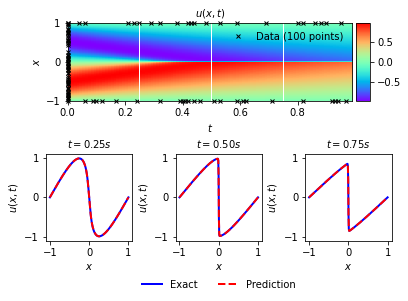

In [8]:
N_u = 100 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)